# Пример использования

#### __```Импорт библиотек```__

In [ ]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import transforms

from torchsummary import summary

#### __```Указание путей к расположению необработанных данных и расположению нового датасета```__

In [ ]:
if os.getcwd() == '/content':
    from google.colab import drive
    drive.mount('/content/drive'); 
    
    # Путь к необработанным данным на диске
    data_directory = '/content/drive/MyDrive/FMCW_Radar'; 

else: data_directory = str(input('Задайте путь к данным с радара: '));

Mounted at /content/drive


#### __```Импорт набора инструментов```__

In [ ]:
!git clone https://github.com/imaks79/assets.git

Cloning into 'assets'...
remote: Enumerating objects: 242, done.
remote: Counting objects: 100% (242/242), done.
remote: Compressing objects: 100% (164/164), done.
remote: Total 242 (delta 136), reused 176 (delta 70), pack-reused 0
Receiving objects: 100% (242/242), 1.11 MiB | 20.61 MiB/s, done.
Resolving deltas: 100% (136/136), done.


In [ ]:
from assets.nn.utils import torch_stats, torch_seed, imshow_predicts, imshow
from assets.nn.processing import train_processing, predict_processing, accuracy, evaluate

from assets.models.resnet import Resnet18_modified

from assets.dataset.raw_to_npy import convert_data, get_class_names
from assets.dataset.dataloader import MyLoader
from assets.dataset.utils import dataset_paths_create

#### __```Указание путей к расположению необработанных данных и расположению нового датасета```__

In [ ]:
data_assignment = 'train';
raw_data_path = os.path.join(data_directory, 'rawdata');
dataset_directory = os.path.join(data_directory, 'adcdata');

#### __```Конвертировать .bin файлы в .npy```__

In [ ]:
# dataset_directory_df = convert_data(raw_data_path, dataset_directory, data_assignment);

#### __```Выбор устройства torch```__

In [ ]:
device, dtype, num_workers = torch_stats();
torch_seed(seed = 42, deterministic = True);

torch version: 1.12
Using device: cuda
cuda:  cu113
Cuda is available: True
number of devices: 1
Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
default data type: torch.float32
available number of workers: 2


#### __```Создание набора преобразований```__

In [ ]:
train_transform =  transforms.Compose([
        transforms.ToTensor(),
    ]);

#### __```Создание датасета из доступных файлов```__

In [ ]:
VALID_RATIO = 0.8;
train_data_path = os.path.join(dataset_directory, 'train');
test_data_path = os.path.join(dataset_directory, 'test');

data_paths, class_to_idx, idx_to_class = dataset_paths_create(train_data_path, test_data_path, VALID_RATIO);

In [ ]:
train_dataset = MyLoader(data_paths['train'], class_to_idx, train_transform);
valid_dataset = MyLoader(data_paths['valid'], class_to_idx, train_transform);


class_names = get_class_names(idx_to_class);

print(f'Доступные классы: {class_names}');
print(f'Число тренеровочных выборок: {len(train_dataset)}');
print(f'Число вилидационных выборок: {len(valid_dataset)}');
try: print('Число тестовых выборок:', {len(data_paths['test'])});
except: print('Тестовая выборка отсутсвует.');

Доступные классы: ['person_running_1', 'door_openning_and_close', 'person_walking_1', 'circle', 'person_standing_1']
Число тренеровочных выборок: 2748
Число вилидационных выборок: 550
Тестовая выборка отсутсвует.


#### __```Создание загрузчиков данных```__

In [ ]:
BATCH_SIZE = 5;

if torch.cuda.is_available(): kwarg = {'generator': torch.Generator(device = 'cuda')};
else: kwarg = {'num_workers': min(BATCH_SIZE, num_workers)};

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, **kwarg);
valid_loader = DataLoader(valid_dataset, batch_size = BATCH_SIZE, shuffle = True, **kwarg);
try: test_loader = DataLoader(data_paths['test'], batch_size = BATCH_SIZE, shuffle = True, **kwarg);
except: print('Тестовая выборка отсутсвует.');

Тестовая выборка отсутсвует.


#### __```Просмотреть созданный набор```__

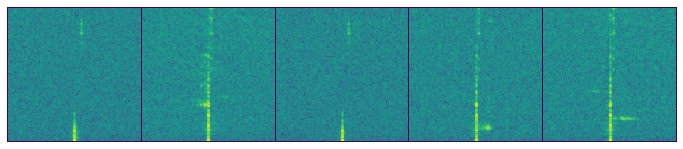

In [ ]:
imshow((next(iter(train_loader)))[0], BATCH_SIZE, device);

#### __```Создание модели НС```__

In [ ]:
model = Resnet18_modified(input_channels = 4, n_classes = len(class_names)).to(device);

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

#### __```Создание параметров обучения НС```__

In [ ]:
LR = 0.001;

criterion = nn.CrossEntropyLoss().to(device);
trainable_parameters = filter(lambda p: p.requires_grad, model.parameters());
optimizer = optim.SGD(trainable_parameters, lr = LR, momentum = 0.9);

#### __```Проверить обученность сети на начальном этапе```__

In [ ]:
best_epoch = 0;
test_loss, test_acc = evaluate(model, valid_loader, criterion, accuracy, device);
print(f'best epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%');

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

best epoch 0: Test Loss: 3.568 | Test Acc: 29.27%


#### __```Начать обучение сети```__

In [ ]:
EPOCHS = 60;
train_processing(EPOCHS, model, train_loader, valid_loader, optimizer, criterion, device);

Epochs:   0%|          | 0/60 [00:00<?, ?it/s]

Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 15s
	Train Loss: 2.093 | Train Acc: 30.61%
	 Val. Loss: 2.517 |  Val. Acc: 30.73%


Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 15s
	Train Loss: 2.109 | Train Acc: 29.16%
	 Val. Loss: 2.536 |  Val. Acc: 31.27%


Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 15s
	Train Loss: 2.061 | Train Acc: 31.56%
	 Val. Loss: 2.384 |  Val. Acc: 33.64%


Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 15s
	Train Loss: 2.043 | Train Acc: 31.95%
	 Val. Loss: 2.775 |  Val. Acc: 31.82%


Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 15s
	Train Loss: 2.049 | Train Acc: 31.78%
	 Val. Loss: 2.353 |  Val. Acc: 32.36%


Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 12 | Epoch Time: 0m 15s
	Train Loss: 2.056 | Train Acc: 32.07%
	 Val. Loss: 2.627 |  Val. Acc: 30.00%


Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 14 | Epoch Time: 0m 15s
	Train Loss: 2.012 | Train Acc: 33.35%
	 Val. Loss: 2.620 |  Val. Acc: 31.09%


Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 16 | Epoch Time: 0m 16s
	Train Loss: 2.069 | Train Acc: 32.30%
	 Val. Loss: 2.775 |  Val. Acc: 28.55%


Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 18 | Epoch Time: 0m 15s
	Train Loss: 2.065 | Train Acc: 33.68%
	 Val. Loss: 2.652 |  Val. Acc: 32.00%


Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 20 | Epoch Time: 0m 15s
	Train Loss: 2.050 | Train Acc: 32.95%
	 Val. Loss: 2.955 |  Val. Acc: 27.09%


Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 22 | Epoch Time: 0m 15s
	Train Loss: 2.040 | Train Acc: 32.61%
	 Val. Loss: 2.284 |  Val. Acc: 36.18%


Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 24 | Epoch Time: 0m 15s
	Train Loss: 2.031 | Train Acc: 32.65%
	 Val. Loss: 2.793 |  Val. Acc: 29.82%


Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 26 | Epoch Time: 0m 15s
	Train Loss: 2.007 | Train Acc: 33.41%
	 Val. Loss: 2.716 |  Val. Acc: 31.64%


Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 28 | Epoch Time: 0m 16s
	Train Loss: 2.018 | Train Acc: 33.14%
	 Val. Loss: 2.722 |  Val. Acc: 26.36%


Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 30 | Epoch Time: 0m 15s
	Train Loss: 2.089 | Train Acc: 32.29%
	 Val. Loss: 2.709 |  Val. Acc: 30.36%


Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 32 | Epoch Time: 0m 15s
	Train Loss: 2.036 | Train Acc: 32.87%
	 Val. Loss: 2.575 |  Val. Acc: 30.55%


Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 34 | Epoch Time: 0m 15s
	Train Loss: 2.043 | Train Acc: 32.85%
	 Val. Loss: 2.412 |  Val. Acc: 33.27%


Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 36 | Epoch Time: 0m 15s
	Train Loss: 2.029 | Train Acc: 33.95%
	 Val. Loss: 2.394 |  Val. Acc: 34.73%


Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 38 | Epoch Time: 0m 15s
	Train Loss: 2.023 | Train Acc: 33.41%
	 Val. Loss: 2.538 |  Val. Acc: 30.18%


Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 40 | Epoch Time: 0m 15s
	Train Loss: 2.021 | Train Acc: 34.76%
	 Val. Loss: 2.750 |  Val. Acc: 31.82%


Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 42 | Epoch Time: 0m 15s
	Train Loss: 2.028 | Train Acc: 32.48%
	 Val. Loss: 2.609 |  Val. Acc: 31.64%


Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 44 | Epoch Time: 0m 15s
	Train Loss: 2.069 | Train Acc: 31.22%
	 Val. Loss: 2.872 |  Val. Acc: 29.09%


Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 46 | Epoch Time: 0m 15s
	Train Loss: 2.027 | Train Acc: 33.18%
	 Val. Loss: 2.638 |  Val. Acc: 29.27%


Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 48 | Epoch Time: 0m 15s
	Train Loss: 2.079 | Train Acc: 32.18%
	 Val. Loss: 2.470 |  Val. Acc: 34.00%


Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 50 | Epoch Time: 0m 15s
	Train Loss: 2.020 | Train Acc: 32.87%
	 Val. Loss: 2.714 |  Val. Acc: 30.18%


Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 52 | Epoch Time: 0m 15s
	Train Loss: 2.004 | Train Acc: 34.32%
	 Val. Loss: 2.677 |  Val. Acc: 32.36%


Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 54 | Epoch Time: 0m 16s
	Train Loss: 2.006 | Train Acc: 34.53%
	 Val. Loss: 2.633 |  Val. Acc: 29.27%


Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 56 | Epoch Time: 0m 16s
	Train Loss: 2.024 | Train Acc: 33.81%
	 Val. Loss: 2.694 |  Val. Acc: 35.82%


Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 58 | Epoch Time: 0m 15s
	Train Loss: 2.018 | Train Acc: 33.60%
	 Val. Loss: 2.887 |  Val. Acc: 30.91%


Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Training:   0%|          | 0/550 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

Epoch: 60 | Epoch Time: 0m 15s
	Train Loss: 1.994 | Train Acc: 34.98%
	 Val. Loss: 2.644 |  Val. Acc: 30.36%


#### __```Проверить лучшую эпоху```__

In [ ]:
model.load_state_dict(torch.load('best_model.pt'));
test_loss, test_acc = evaluate(model, valid_loader, criterion, accuracy, device);
print(10 * '--', f'\nbest epoch {best_epoch}: Test Loss: {test_loss:.3f} | Test Acc: {test_acc * 100:.2f}%');

Evaluating:   0%|          | 0/110 [00:00<?, ?it/s]

-------------------- 
best epoch 0: Test Loss: 2.284 | Test Acc: 36.18%


#### __```Начать тестирование сети```__

In [ ]:
try: data_to_imshow, predicts, truth, df = predict_processing(model, test_loader, device, class_names);
except: print('Тестовая выборка отсутсвует.');

#### __```Просмотреть результат тестирования сети```__

In [ ]:
num_batches_to_show = 1;
try: imshow_predicts(data_to_imshow, BATCH_SIZE, num_batches_to_show, predicts, truth, device, class_names);
except: print('Тестовая выборка отсутсвует.');